# Implementación Modificación 1
Differentiable Logic Cellular Automata: from Game of Life to Pattern Generation

---

**Note for the reader (as of March 20, 2025):**: We tested reproducibility of the results reported in
this article using publicly available Colab notebooks with T4 GPUs. Determinism
is ensured by setting the os.environ['XLA_FLAGS'] = '
--xla_gpu_deterministic_ops=true' flag, which resolves non-determinism caused by
specific JAX optimization routines, though at the cost of speed and efficiency.

In [1]:
# We tested reproducibility on jax version 0.4.33

!pip install jax[cuda12_pip]==0.4.33
!pip install jaxlib==0.4.33

# You might need to restart the kernel

In [2]:
"""Reproducibility:

This flag is necessary for ensuring reproducibility on Colab.
Removing it significantly boosts performance (5-10x) but compromises
result consistency due to inherent GPU non-determinism.
"""

import os

os.environ['XLA_FLAGS'] = ' --xla_gpu_deterministic_ops=true'

In [3]:
# @title Imports and Notebook Utilities
from collections import namedtuple
from datetime import datetime
from functools import partial
import io
import itertools
from base64 import b64decode
from typing import List, Optional, Sequence, Tuple

from einops import rearrange
import flax.linen as nn
import flax.linen as nn
from IPython.display import HTML, Image, clear_output
import jax
print(jax.__version__)
from jax import grad
from jax.lax import conv_general_dilated_patches
import jax.numpy as jnp
import jax.random as random
from jax.tree_util import tree_leaves, tree_map
from matplotlib import colors
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.ticker import MaxNLocator
import numpy as np
import optax
import pickle
import PIL
import PIL.Image, PIL.ImageDraw, PIL.ImageFont, PIL.ImageOps
import requests
import networkx as nx  #Nueva


os.environ['FFMPEG_BINARY'] = 'ffmpeg'

0.4.33


In [4]:
# @title Hyperparameters

# Index of the pass-through gate used for network initialization.
PASS_THROUGH_GATE = 3
DEFAULT_PASS_VALUE = 10.0

# Number of possible gates with 2 inputs and 1 output.
NUMBER_OF_GATES = 16

"""
Fire rate for asynchronicity.

60% of cells will perform the update,
40% will have the update masked.
"""
FIRE_RATE = 0.6

TARGET_EMOJI = "🦎"
TARGET_SIZE_EMOJI = 20
TARGET_SIZE_G = 16
TARGET_SIZE_ASYNC = 14
TARGET_SIZE = 16

In [5]:
def prepare_adjacency_tensor(G, N_total, max_k=9, c_idx=4):
    """
    Convierte un grafo k=8-regular de NetworkX en un tensor de índices de JAX 
    normalizado a 9 inputs.

    Args:
        G: Objeto nx.Graph (debe ser k=8-regular).
        N_total: Número total de nodos.
        max_k: Tamaño fijo del vecindario (9).
        c_idx: Índice donde se coloca el nodo central (4).

    Returns:
        JAX array de índices con shape (N_total, 9).
    """
    
    # Usamos un índice de padding que apunta a la fila de ceros agregada a las features.
    padding_index = N_total 
    
    # Inicializar el tensor de índices fijos (N_total, 9) con el valor del nodo central
    adj_indices_padded_np = np.full((N_total, max_k), padding_index, dtype=np.int32)
    
    for i in range(N_total):
        # Obtener los 8 vecinos reales del nodo i
        neighbors = list(G.neighbors(i))
        
        # --- 1. Colocar el nodo central ---
        # La posición 4 es el propio nodo i.
        adj_indices_padded_np[i, c_idx] = i 
        
        # --- 2. Colocar a los 8 vecinos en las 8 posiciones restantes ---
        
        # Índices disponibles en el patch (excluyendo la posición central 4)
        available_indices = [idx for idx in range(max_k) if idx != c_idx]
        
        # El grafo k=8-regular garantiza 8 vecinos, por lo que llenamos las 8 posiciones.
        for j, neighbor_idx in enumerate(neighbors):
            if j < len(available_indices): # Siempre True si |neighbors| <= 8
                # Asignar el vecino a la j-ésima posición disponible
                adj_indices_padded_np[i, available_indices[j]] = neighbor_idx
            # Nota: Si el grafo es estrictamente k=8-regular, no se requiere padding (else).
                
    # --- 3. Convertir a JAX Array ---
    return jnp.array(adj_indices_padded_np)

In [6]:
# @title Utils and Plotting


def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img


def load_byte(byte, max_size=TARGET_SIZE):
  img = PIL.Image.open(io.BytesIO(byte))
  img.thumbnail((max_size, max_size), PIL.Image.LANCZOS)
  img = np.float32(img) / 255.0
  # premultiply RGB by Alpha
  img[..., :3] *= img[..., 3:]
  return img

def visualize(frames, namefile, size, negate=1):
  # Create and save animation
  fig, ax = plt.subplots(figsize=(size, size))
  ax.set_xticks([])
  ax.set_yticks([])

  def animate(frame):
    ax.clear()
    ax.set_xticks([])
    ax.set_yticks([])

    if negate:
      frame = 1 - frame

    return [ax.imshow(frame, cmap='binary')]

  anim = animation.FuncAnimation(fig, animate, frames=frames, interval=200, blit=True)

  # Save the gif
  writer = animation.PillowWriter(fps=2)
  anim.save(namefile, writer=writer)
  plt.close()


def plot_show(img, negate=1):
  if negate:
    img = 1 - img
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
  ax.imshow(img, cmap='binary')
  ax.axis('off')
  plt.tight_layout()
  plt.show()


# Plot the histogram related to the statistics of the gates.
def plot_hist_gates(
    net, save_path=None, title='Distribution of Gates (Sorted)'
):
  gate_types = [
      'FALSE',
      'AND',
      'A AND (NOT B)',
      'A',
      '(NOT A) AND B',
      'B',
      'XOR',
      'OR',
      'NOR',
      'XNOR',
      'NOT B',
      'A OR (NOT B)',
      'NOT A',
      '(NOT A) OR B',
      'NAND',
      'TRUE',
  ]

  gate_counts = np.bincount(net, minlength=len(gate_types))
  sorted_indices = np.argsort(gate_counts)
  sorted_counts = gate_counts[sorted_indices]
  sorted_gate_types = [gate_types[i] for i in sorted_indices]
  fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

  ax.barh(
      sorted_gate_types,
      sorted_counts,
      color='#2E86C1',
      alpha=0.7,
      edgecolor='white',
      linewidth=1,
  )

  ax.set_xlabel('#Gates', fontsize=12, fontweight='bold')
  ax.set_ylabel('Type of gate', fontsize=12, fontweight='bold')
  ax.set_title(
      'Distribution of Gates (Sorted)', fontsize=14, fontweight='bold', pad=20
  )

  plt.style.use('seaborn-v0_8-darkgrid')
  ax.grid(True, linestyle='--', alpha=0.7, axis='x')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax.set_facecolor('#f8f9fa')
  fig.set_facecolor('white')
  plt.tight_layout()

  if save_path:
    with open(save_path, 'wb') as f:
      plt.savefig(f, format='svg')
  plt.show()


# Plot the training loss functions.
def plot_training_progress(
    loss_train, loss_test, compute_every, save_path=None
):
  plt.style.use('seaborn-v0_8-darkgrid')

  fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

  ax.grid(True, color='gray', linestyle='-', linewidth=0.8, alpha=0.3)

  ax.plot(
      loss_train,
      color='#2E86C1',
      linewidth=2,
      label='Soft Gates Loss',
      alpha=0.9,
  )

  ax.plot(
      np.arange(0, len(loss_train), compute_every),
      loss_test,
      color='#E74C3C',
      linestyle='--',
      linewidth=2,
      label='Hard Gates Loss',
      alpha=0.9,
  )

  ax.grid(True, linestyle='--', alpha=0.7)

  ax.set_xlabel('Training Steps', fontsize=12, fontweight='bold')
  ax.set_ylabel('Loss Value', fontsize=12, fontweight='bold')
  ax.set_title(
      'Training Progress - Soft vs Hard Gates',
      fontsize=14,
      fontweight='bold',
      pad=20,
  )

  ax.legend(
      frameon=True, fancybox=True, shadow=True, fontsize=10, loc='upper right'
  )

  for spine in ax.spines.values():
    spine.set_linewidth(1.5)

  ax.set_facecolor('#f8f9fa')
  fig.set_facecolor('white')

  plt.tight_layout()

  if save_path:
    with open(save_path, 'wb') as f:
      plt.savefig(f, format='svg')

  plt.show()

In [7]:
# @title Función de Python: prepare_adjacency_tensor para Grafo k=8


def prepare_adjacency_tensor(G, N_total, max_k=9, c_idx=4):
    """
    Convierte un grafo k=8-regular de NetworkX en un tensor de índices de JAX 
    normalizado a 9 inputs.

    Args:
        G: Objeto nx.Graph (debe ser k=8-regular).
        N_total: Número total de nodos.
        max_k: Tamaño fijo del vecindario (9).
        c_idx: Índice donde se coloca el nodo central (4).

    Returns:
        JAX array de índices con shape (N_total, 9).
    """
    
    # Usamos un índice de padding que apunta a la fila de ceros agregada a las features.
    padding_index = N_total 
    
    # Inicializar el tensor de índices fijos (N_total, 9) con el valor del nodo central
    adj_indices_padded_np = np.full((N_total, max_k), padding_index, dtype=np.int32)
    
    for i in range(N_total):
        # Obtener los 8 vecinos reales del nodo i
        neighbors = list(G.neighbors(i))
        
        # --- 1. Colocar el nodo central ---
        # La posición 4 es el propio nodo i.
        adj_indices_padded_np[i, c_idx] = i 
        
        # --- 2. Colocar a los 8 vecinos en las 8 posiciones restantes ---
        
        # Índices disponibles en el patch (excluyendo la posición central 4)
        available_indices = [idx for idx in range(max_k) if idx != c_idx]
        
        # El grafo k=8-regular garantiza 8 vecinos, por lo que llenamos las 8 posiciones.
        for j, neighbor_idx in enumerate(neighbors):
            if j < len(available_indices): # Siempre True si |neighbors| <= 8
                # Asignar el vecino a la j-ésima posición disponible
                adj_indices_padded_np[i, available_indices[j]] = neighbor_idx
            # Nota: Si el grafo es estrictamente k=8-regular, no se requiere padding (else).
                
    # --- 3. Convertir a JAX Array ---
    return jnp.array(adj_indices_padded_np)

In [8]:
# @title Model definition


def get_moore_connections(key):
  """Generate Moore neighborhood connections for a 9x1 vector.

  Center element is at index 4 and connects to all other elements.
  """
  neighbors = jnp.array([0, 1, 2, 3, 5, 6, 7, 8])
  a = neighbors
  b = jnp.full_like(neighbors, 4)
  perm = jax.random.permutation(key, neighbors.shape[0])
  a = a[perm]
  b = b[perm]
  return a, b


# From https://github.com/Felix-Petersen/difflogic/tree/main/difflogic
def get_unique_connections(in_dim, out_dim, key):
  assert (
      out_dim * 2 >= in_dim
  )  # Number of neurons must not be smaller than half of inputs
  x = jnp.arange(in_dim)
  # Take pairs (0, 1), (2, 3), (4, 5), ...
  a = x[::2]
  b = x[1::2]
  m = min(a.shape[0], b.shape[0])
  a = a[:m]
  b = b[:m]
  # If needed, add pairs (1, 2), (3, 4), (5, 6), ...
  if a.shape[0] < out_dim:
    a_ = x[1::2]
    b_ = x[2::2]
    m = min(a_.shape[0], b_.shape[0])
    a = jnp.concatenate([a, a_[:m]])
    b = jnp.concatenate([b, b_[:m]])
  # If still needed, add pairs with larger offsets
  offset = 2
  while out_dim > a.shape[0] and offset < in_dim:
    a_ = x[:-offset]
    b_ = x[offset:]
    a = jnp.concatenate([a, a_])
    b = jnp.concatenate([b, b_])
    offset += 1

  if a.shape[0] >= out_dim:
    a = a[:out_dim]
    b = b[:out_dim]
  else:
    raise ValueError(
        f'Could not generate enough unique connections: {a.shape[0]} <'
        f' {out_dim}'
    )

  # Random permutation
  perm = jax.random.permutation(key, out_dim)
  a = a[perm]
  b = b[perm]

  return a, b


def bin_op_all_combinations(a, b):
  # Implementation of binary operations between two inputs for all the different operations
  return jnp.stack(
      [
          jnp.zeros_like(a),
          a * b,
          a - a * b,
          a,
          b - a * b,
          b,
          a + b - 2 * a * b,
          a + b - a * b,
          1 - (a + b - a * b),
          1 - (a + b - 2 * a * b),
          1 - b,
          1 - b + a * b,
          1 - a,
          1 - a + a * b,
          1 - a * b,
          jnp.ones_like(a),
      ],
      axis=-1,
  )



def bin_op_s(a, b, i_s):
  # Compute all possible operations
  combinations = bin_op_all_combinations(
      a, b
  )  # Shape: (n_gate, n_possible_gates, 16)
  """
    Calculate the weighted sum of all possible gate operations.
    During training (soft decoding), the weights are the probabilities
    of each gate type. During inference (hard decoding), the weights
    are a one-hot vector representing the selected gate type.
    """
  result = jax.numpy.sum(combinations * i_s[None, ...], axis=-1)
  return result


def decode_soft(weights):
  # From the weights vector compute the probability distribution of choosing each gate using softmax
  return nn.softmax(weights, axis=-1)


def decode_hard(weights):
  return jax.nn.one_hot(
      jnp.argmax(weights, axis=-1), 16
  )  # Return the gate with maximum probability.


# Initialize gates as pass through gate
def init_gates(
    n,
    num_gates=NUMBER_OF_GATES,
    pass_through_gate=PASS_THROUGH_GATE,
    default_pass_value=DEFAULT_PASS_VALUE,
):
  """Initializes a gate matrix with default pass-through values.

  Args:
      n: The number of rows in the gate matrix.
      num_gates: The number of gates (columns). Defaults to NUMBER_OF_GATES.
      pass_through_gate: The index of the pass-through gate column. Defaults to
        PASS_THROUGH_GATE.
      default_pass_value: The default value for the pass-through gate. Defaults
        to DEFAULT_PASS_VALUE.

  Returns:
      An array representing the initialized gate matrix.
  """
  gates = jnp.zeros((n, num_gates))
  gates = gates.at[:, pass_through_gate].set(default_pass_value)
  return gates


def init_gate_layer(key, in_dim, out_dim, connections):

  # With 'random' connections the input of each gate are sampled randomly from the previous layer.
  if connections == 'random':
    key1, key2 = jax.random.split(key)

    c = jax.random.permutation(key2, 2 * out_dim) % in_dim
    c = jax.random.permutation(key1, in_dim)[c]

    c = c.reshape(2, out_dim)

    indices_a = c[0, :]
    indices_b = c[1, :]

  # With 'unique' connections each gate will have a different pair of inputs.
  elif connections == 'unique':
    indices_a, indices_b = get_unique_connections(in_dim, out_dim, key)

  # With 'first_kernel' the connections are specifically designed to mimic the Moore neighborhood.
  
  elif connections == 'first_kernel':                     #**
    indices_a, indices_b = get_moore_connections(key)
  else:
    raise ValueError(f'Connection type {connections} not implemented')

  wires = [indices_a, indices_b]
  gate_logits = init_gates(out_dim)
  return gate_logits, wires


def init_logic_gate_network(hyperparams, params, wires, key):
  for i, (in_dim, out_dim) in enumerate(
      zip(hyperparams['layers'][:-1], hyperparams['layers'][1:])
  ):
    key, subkey = jax.random.split(key)
    gate_logits, gate_wires = init_gate_layer(
        subkey, int(in_dim), int(out_dim), hyperparams['connections'][i]   #**
    )
    params.append(gate_logits)
    wires.append(gate_wires)


def init_perceive_network(hyperparams, params, wires, key):
  for i, (in_dim, out_dim) in enumerate(
      zip(hyperparams['layers'][:-1], hyperparams['layers'][1:])
  ):
    key, subkey = jax.random.split(key)
    gate_logits, gate_wires = init_gate_layer(
        subkey, int(in_dim), int(out_dim), hyperparams['connections'][i]
    )
    """
    Replicate the gate logits for each of the 'n_kernels' perception kernels.
    This allows for parallel computation of the perception module,
    as all kernels share the same underlying structure and wiring.
    """
    params.append(
        gate_logits.repeat(hyperparams['n_kernels'], axis=0).reshape(
            hyperparams['n_kernels'], out_dim, NUMBER_OF_GATES
        )
    )
    wires.append(gate_wires)


# In the current implementation all the kernels share the same connection scheme
def init_diff_logic_ca(hyperparams, key):

  key, subkey = jax.random.split(key)
  """Initialize parameters for the update and perceive networks.

   Each network's parameters will be stored as a list of gate logits.

   'update':  List of gate logits for the update network.
              Each element is a JAX array with shape (out_dim, 16),
              where out_dim is the output dimension of the layer.
   'perceive': List of gate logits for the perceive network.
               Each element is a JAX array with shape (n_kernels * out_dim, 16),
               where n_kernels is the number of perception kernels
               and out_dim is the output dimension of the layer.
  """
  params = {'update': [], 'perceive': []}

  """Initialize wiring for the update and perceive networks.

   Each network's wiring will be stored as a list of connection indices.

   'update':  List of connection indices for the update network.
              Each element is a tuple of two JAX arrays (indices_a, indices_b)
              representing the input indices for each gate.
   'perceive': List of connection indices for the perceive network.
               The perceive kernels share the same wiring, so this list
               contains a single tuple of connection indices (indices_a, indices_b).
  """
  wires = {'update': [], 'perceive': []}

  # Initialize the gate
  init_logic_gate_network(
      hyperparams['update'], params['update'], wires['update'], subkey    
  )

  key, subkey = jax.random.split(key)

  # Initialize perceive vector
  init_perceive_network(
      hyperparams['perceive'], params['perceive'], wires['perceive'], subkey
  )

  return params, wires


def run_layer(logits, wires, x, training):
  """Args:

      x: input vector, shape (input_dim, 1).
      wires: wire configuration, shape (out_dim, 1).
      logits: gate parameters, shape (n_out, 16).

  Returns:
      If training is True, the expected gate values.
      If training is False, the gates with maximum probability.
  """

  a = x[..., wires[0]]
  b = x[..., wires[1]]
  logits = jax.lax.cond(training, decode_soft, decode_hard, logits)
  out = bin_op_s(a, b, logits)
  return out


def run_update(params, wires, x, training):
  for g, c in zip(params, wires):
    x = run_layer(g, c, x, training)
  return x


def run_perceive(params, wires, x, training):
  """Applies a perception layer to a patch.

  Args:
      params: List of kernel parameters for each layer.
      wires: List of wire configurations for each layer.
      x: Input patch, shape [batch_size, patch_size, channel_size].
      training: Boolean indicating training mode.

  Returns:
      Output feature vector, shape [batch_size, channel_size].
  """

  # Apply each layer using vmap for kernel parallelism.
  run_layer_map = jax.vmap(run_layer, in_axes=(0, None, 0, None))
  x_prev = x
  x = x.T  # [channel_size, batch_size, patch_size]

  """
    Duplicate 'x' to create n_kernels copies for the first layer, 
    which all share the same input.
    Subsequent layers receive unique inputs.
    """
  x = jnp.repeat(
      x[None, ...], params[0].shape[0], axis=0
  )  # [n_kernels, channel_size, batch_size, patch_size]

  # Iterate through layers, applying kernels and wire configurations.
  for g, c in zip(params, wires):
    x = run_layer_map(g, c, x, training)

  x = rearrange(                              #**
      x, 'k c s -> (c s k)'
  )  # [channel_size * patch_size * n_kernels]

  return jnp.concatenate(                          #**
      [x_prev[4, :], x], axis=-1
  )  # Concatenate the original input.


def run_circuit(params, wires, x, training):
  x = run_perceive(params['perceive'], wires['perceive'], x, training)
  x = run_update(params['update'], wires['update'], x, training)
  return x

In [9]:
# Test cases
key = jax.random.PRNGKey(0)
key_init, key = jax.random.split(key, 2)
n_kernels = 4
layers = [128] * 10 + [64, 32, 16]
connections = ['unique'] * len(layers)

"""Recap: Structure of the hyperparameters:

'update' is referring to the diff logic network of the update.
- Layers:  number of gates per layer (with exception of the first layer
           which represent the number of inputs)
- Connections: specify the topology of the connections, how the gates
           are connected. It can be mainly 'random', 'unique' or 'first_kernel'
           which will be used to the first kernel layer.

'perceive' is referring to the diff logic networks of the perception
          (or "convolutional kernels").
- Layers:  number of gates per layer (with exception of the first layer which
           represent the number of inputs)
- Connections: specify the topology of the connections, how the gates are connected.
           It can be mainly 'random', 'unique' or 'first_kernel' which is used
           only for the first kernel layer to enforce connections that mimic the cell-interactions.

For simplicity, all perception kernels share the same structure (type of connections,
number of layers, and number of gates per layer). They are evaluated in parallel.

"""

hyperparams = {
    'update': {'layers': layers, 'connections': connections},
    'perceive': {
        'n_kernels': n_kernels,
        'layers': [9, 8, 4, 2, 1],      #Cambio: Modificar el primer valor en la lista 'layers' dentro de perceive de 9 a $N$. Para abrir la topologia
        'connections': ['first_kernel', 'unique', 'unique', 'unique'],
    },
}

training = True
params, wires = init_diff_logic_ca(hyperparams, key_init)
print(
    params['perceive'][0]
    .reshape((
        hyperparams['perceive']['n_kernels'],
        hyperparams['perceive']['layers'][1],
        16,
    ))
    .shape
)
grid_ch_dim = 16
inp = jnp.ones((3 * 3, grid_ch_dim)).astype(jnp.float32)
x = run_circuit(params, wires, inp, training)
print('INPUT SHAPE', inp.shape)
print('OUTPUT SHAPE', x.shape)

# The output of the circuit is the new state for the central cell with shape (1, grid_ch_dim)
assert x.shape == (1, grid_ch_dim)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(4, 8, 16)
INPUT SHAPE (9, 16)
OUTPUT SHAPE (1, 16)


In [10]:
# @title Nueva Función: get_adjacency_patches

# Se utiliza la variable PADDING_INDEX definida en el bloque anterior (Celda 1)
# para el padding. Es un valor estático fuera de la función JIT.

@partial(jax.jit, static_argnums=(2, 3))
def get_adjacency_patches(node_features, adjacency_indices_padded, max_neighbors=9, center_index=4):
  """
  Realiza la agregación de features de los vecinos consultando el tensor de adyacencia
  pre-procesado y normalizado.
  """
  
  # Añadir la fila de padding (ceros) al final del array de features para manejar el PADDING_INDEX
  padding_feature = jnp.zeros_like(node_features[:1]) 
  node_features_padded = jnp.concatenate([node_features, padding_feature], axis=0)

  # jnp.take selecciona los features de los nodos de entrada basándose en los índices normalizados.
  # El índice N_total_nodes (PADDING_INDEX) apuntará a la fila de ceros recién añadida.
  patches = jnp.take(
      node_features_padded,
      adjacency_indices_padded,
      axis=0
  )
  
  return patches

In [11]:
# @title Test (Modificado para usar lógica de Grafo)

key = random.PRNGKey(42)
N = 3 # Grilla 3x3 = 9 nodos
C = 1
patch_size = 3 
N_total = N * N # 9 nodos

# 1. Definir el tensor de adyacencia de PRUEBA (N=9, k=8)
# Para un test simple, podemos simular que cada nodo es el centro y que los 9 inputs
# son simplemente [0, 1, 2, 3, 4, 5, 6, 7, 8] (sin un grafo k=8 real)
# En una prueba real, crearías un grafo k=8 de 9 nodos aquí.

# Creamos un tensor que solo mapea las features en orden (simulando 9 inputs distintos)
adjacency_indices_padded_test = jnp.arange(N_total * 9).reshape(N_total, 9) % N_total


grid = random.randint(key, (N, N, C), minval=0, maxval=2).astype(jnp.float32)

# Aplanar el input de la grilla a features de nodo (N_total_nodes, C)
node_features = grid.reshape(-1, grid.shape[-1]) 

# 2. Reemplazar la función de cuadrícula con la función de grafo
patches = get_adjacency_patches(
    node_features, 
    adjacency_indices_padded_test, 
    max_neighbors=patch_size * patch_size # 9
)

print(f"Grid\n {grid[..., 0]}")

# NOTA: Las siguientes líneas de impresión ya no tienen sentido porque patches ya no es un arreglo 2D convolucional
# print(patches[-1, :, 1].reshape(1, 3, 3)) 
# print(patches[-1:, 1].reshape(-1))

# La aserción final sigue siendo válida si patches tiene el shape esperado (9, 9, 1)
assert patches.shape == (N * N, patch_size * patch_size, C)

Grid
 [[1. 0. 1.]
 [1. 1. 1.]
 [1. 0. 0.]]


In [12]:
# @title run iterations


# patches = [batch_size, n_patches, patch_size x patch_size, channels]
def v_run_circuit_patched(patches, params, wires, training):
  run_circuit_patch = jax.vmap(
      run_circuit, in_axes=(None, None, 0, None)
  )  # vmap over the patches
  x = run_circuit_patch(params, wires, patches, training)
  return x

@jax.jit
# Aceptar adjacency_indices_padded
def run_async(grid, params, wires, training, periodic, key, adjacency_indices_padded):


  node_features = grid.reshape(-1, grid.shape[-1]) # Aplanar la grilla a features de nodo (N_total_nodes, C)
    
  # REEMPLAZAR la lógica de cuadrícula con la lógica de grafo
  # patches = get_grid_patches(...) # REMOVER
  patches = get_adjacency_patches(node_features, adjacency_indices_padded) # <-- NUEVO
    
  x_new = v_run_circuit_patched(patches, params, wires, training)
  x_new = x_new.reshape(grid.shape)
  # ... resto de la lógica async ...
  update_mask_f32 = (
      jax.random.uniform(key, x_new[..., :1].shape) <= FIRE_RATE
  ).astype(jax.numpy.float32)
  x = grid * (1 - update_mask_f32) + x_new * update_mask_f32
  return x

@jax.jit
# Aceptar adjacency_indices_padded
def run_sync(grid, params, wires, training, periodic, adjacency_indices_padded):

  node_features = grid.reshape(-1, grid.shape[-1])   # Aplanar la grilla a features de nodo (N_total_nodes, C)
    
  # REEMPLAZAR la lógica de cuadrícula con la lógica de grafo
  # patches = get_grid_patches(...) # REMOVER
  patches = get_adjacency_patches(node_features, adjacency_indices_padded) # <-- NUEVO
    
  x_new = v_run_circuit_patched(patches, params, wires, training)
  x_new = x_new.reshape(grid.shape[0], grid.shape[1], grid.shape[2])
  return x_new

@partial(jax.jit, static_argnames=['num_steps', 'periodic', 'async_training'])
# Aceptar adjacency_indices_padded
def run_iter_nca(grid, params, wires, training, periodic, num_steps, async_training, key, adjacency_indices_padded):
  def body_fn(carry, i):
    grid, key = carry
    if async_training:
      key, subkey = jax.random.split(key)
      # Pasar el nuevo argumento
      x = run_async(grid, params, wires, training, periodic, subkey, adjacency_indices_padded) 
    else:
      # Pasar el nuevo argumento
      x = run_sync(grid, params, wires, training, periodic, adjacency_indices_padded) 
    return (x, key), 0

  (grid, key), _ = jax.lax.scan(
      body_fn, (grid, key), jnp.arange(0, num_steps, 1)
  )
  return grid


v_run_iter_nca = jax.vmap(
    run_iter_nca, in_axes=(0, None, None, None, None, None, None, None, None)
)

In [13]:
# @title Definiciones de Estado y Pérdida (Requerido)

TrainState = namedtuple('TrainState', 'param opt_state key')

def init_state(hyperparams, opt, seed):
  key = random.PRNGKey(seed)
  key, subkey = random.split(key, 2)
  params, wires = init_diff_logic_ca(hyperparams, subkey)
  opt_state = opt.init(params)
  return TrainState(params, opt_state, key), wires

# --- Funciones de Pérdida y Entrenamiento (Se redefinen para Lizard, pero se necesitan aquí globalmente si se llama desde otros tests) ---

def loss_f_global(params, wires, train_x, train_y, periodic, num_steps, async_training, key, adjacency_indices_padded):
  # Esta versión global es solo para asegurar que v_run_iter_nca pueda ser llamada.
  # La versión específica del Lizard (Celda 39) sobrescribe esto.
  def eval(params, training):
    y = v_run_iter_nca(
        train_x, params, wires, training, periodic, num_steps, async_training, key, adjacency_indices_padded
    )
    # Usar una pérdida genérica que no rompa
    return jax.numpy.square(y).sum() 

  return eval(params, 1), {'hard': eval(params, 0)}

val_and_grad_global = jax.value_and_grad(loss_f_global, argnums=0, has_aux=True)

# Helper function
upd_f = lambda p: p

# Nota: La definición de train_step para el Lizard se encuentra en la Celda 39 y usa la variable correcta.

----------------------------------------------------------------------

In [14]:
# @title base64 lizard image
'''
Importing the Lizard image in base64 format.
'''
lizard_byte = b64decode("iVBORw0KGgoAAAANSUhEUgAAACAAAAAgCAYAAABzenr0AAAAAXNSR0IArs4c6QAAAERlWElmTU0AKgAAAAgAAYdpAAQAAAABAAAAGgAAAAAAA6ABAAMAAAABAAEAAKACAAQAAAABAAAAIKADAAQAAAABAAAAIAAAAACshmLzAAAFrElEQVRYCcVXzW9bRRD/7b73bOfbaUnlfualtETQiDoUiYoPyZYoibi0pqQS6gH7ABKnNleEmlZIPcAh4i9wOABSU9RcUJMiSBASKiCIQQRSVClu2qahH66DE3++t8usU6e29RJwaGGl9e7OzM7Mm/nt7Br4nxtby752pjcsmRyUEhPSyEUQmkiuJb8enr7qpjMH/GQ8qviM4RCz3UkBRFaVXyeDr7aPMT5YwZMI8+HekxW0B7BwTIE+3BsQkOPl+vnsEmS9Dtvr6cBro/Fy3r+ZO6aAQh3Qx+agTS8g/8buomHPOzGIx1uQfbtroJQKPtxTjJIE/FLPhdaDEccUSCn36j8moP2QALudK36g9cImWE9tAAHSLBIIIzSGqR+nMAa45VbzmptjBAh08Rx9OUtbkDsa4OYM8s3HYJH1UuOMT9K8/FS0l3i1jI4RYJL9JB9xQ5DxFp2h08PxRL2GRu0+ZBiTITIURzqtojIi+sb6azFcknV0wDayIyRQ/Do3heP0z0n0WgLdDTo895ywX70wIqan+sWVONj8fHkkSrr/0eiYAgUmdvaliJTsXFZIXKZodNZpkORAypaBKQJfbn7uKyQXBgAJkUyYTtYIpMeJTjKqlsiIcrpa7n5Mqzm0VpVQ4zK6v8nAwQ0udF3PYNKW+IhSMp2xYSWTkLdvx5HNhnDyeqxcBRlXGFHNpO4F4UoUWLD6CDumQO1STYHRFixyNWdjlvqW2TSeJgeCLQb2UE1we1vBH91l8q6uYzgX8C7vWv4lXMRpZlJX9CR1+iK7QkaRnCNAR4xQHiW+X1iso86F8eeadPPgRhfadI62Syl8R6C84OL4NW3jDuGDMhXji0v91rXZQUKln7yPMZ/PZN5WZTQm9FzQqU5oyouKRl/CpBElz/YrumTiQwGeWxIy4KHj2O7m6Li8iDaDo3lzHU58eROZVhdmPdyX5TwsFxd9sCy11ccY87DmFpX/t+ThL2KKWN0cQUjGV0JFkXhd/Dblv7VzJ77RGtBAp4Dt34jdUwvoTFmoI+MvUkryTTq+TXHMbNkC+8qVJFyekPTtiMu+0Xi10fK1YwrYmZ5zlP8AJSgp7yRM+cc84PFAazfRUW/g+WYdp0fmMB1oQ7rZQFMih0VKzc25DN7bXo9LC5mYODreXW5otbkjCNXdT7nv5pJFkEot781mh2yG7pmsnTx/t4Dwyz5caHOD38qi8U4ekhzZ5dHwLDm3rdHjVxfaakbL6Y4RKBfAu9sP0VH34sTVoSL9k16T6TJqUIS2Egj3Nep4ho7pNpobeYH8zSw+dmv4+s/CxMIro8EKXQ6Lv3fAYRNOml40uMdZq9ffuKG1WCEPeA346UTsOz+H9w9uw2eJPH63RAdCa2PAEYRONitoXISRSftlJo1UIoGLW7dSkBrRSMd06agJH9WMzRSRG5YIUAKHKvZWLRwxUCVTsSzmVvAhaFpcMVjbprhweYKTqULsOzoVWqqA9msZtNBp8UDurdjssKgpAqWXEt/TuayqUAAMw7QhBxYLLHQxVZh5ko5lC3VNXd2M+x1sVpBqioClZ2OqppOGZFGLYRSvYg3slKrxN/Ji6PuCwBRd4YRH4omVelJhtWxRMwjpkrmr6gMl3SQ9SXoHtK7ooxLeWW9MbqYqmaHa/AuBcunw6Jo21mSuKK6asOGecdqowusVUnTjyOexkkjdp70zzRoz6c5Cku4Iq2+MgRxj4ANKhi7vU+XyNWGgZERaLEL6oeswRZlxxc8J+cEtIQdLssu4oaoKaRJNOUIvbqxEbV0RIEWrN7rM6IE6QwLF/KvnmjwyFlIbKH3Kb3CwoNU3OqHmD94BUnrvL11UGVBNOaFGul8OqVFd8aWHyUNxQBnhZ3uilPCwmpc3CsGE7BsLlmgPzQFlQOXflvIYxbmYDvXCElqu3+lhUnLoPx//Aq5HH06LSa+UAAAAAElFTkSuQmCC")

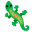

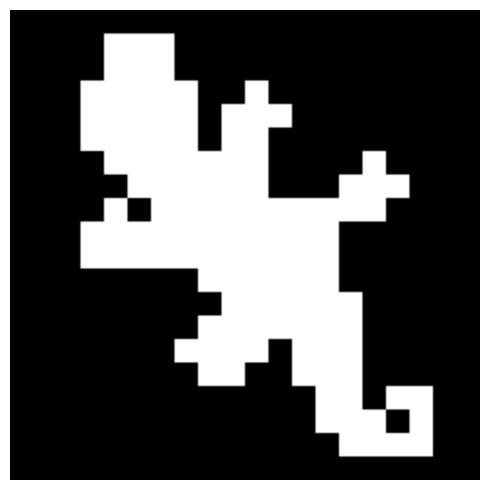

In [15]:
# @title Learning to Grow the lizard

# Outline of the lizard, creating a mask with 1 and 0 to use as target image
target_img = load_byte(lizard_byte, TARGET_SIZE_EMOJI) > 0.26

target_img = (
    target_img[..., 2] | target_img[..., 1] | target_img[..., 0]
).astype(jnp.float32)


plot_show(zoom(target_img[..., None], 8))

In [16]:
# @title Creación del Grafo k=8 (Ubicación: Antes de la Celda 34)

N_nodes_lizard = TARGET_SIZE_EMOJI * TARGET_SIZE_EMOJI # 20*20 = 400
MAX_NEIGHBORS = 9
CENTER_INDEX = 4

# Crear el grafo 8-regular
# La función random_regular_graph requiere que N*d sea par. 400*8 es 3200 (par).
G_lizard_k8 = nx.random_regular_graph(d=8, n=N_nodes_lizard) 

# Generar el tensor de JAX
adjacency_indices_padded_lizard = prepare_adjacency_tensor(G_lizard_k8, N_nodes_lizard, MAX_NEIGHBORS, CENTER_INDEX)

In [17]:
hyperparams = {'perceive': {}, 'update': {}}
hyperparams['seed'] = 23
hyperparams['lr'] = 0.06
hyperparams['batch_size'] = 1
hyperparams['num_epochs'] = 3500
hyperparams['num_steps'] = 12
hyperparams['channels'] = 128
hyperparams['periodic'] = 1
hyperparams['perceive']['n_kernels'] = 4
hyperparams['perceive']['layers'] = [9, 8, 4, 2, 1]
hyperparams['perceive']['connections'] = [
    'unique', 
    'unique',
    'unique',
    'unique',
]
#Modificamos first kernel por unique

init = (
    hyperparams['perceive']['n_kernels']
    * hyperparams['channels']
    * hyperparams['perceive']['layers'][-1]
    + hyperparams['channels']
)
hyperparams['update']['layers'] = (
    [init] + [512] * 8 + [256, hyperparams['channels']]
)
hyperparams['update']['connections'] = ['unique'] * len(
    hyperparams['update']['layers']
)
hyperparams['async_training'] = False

In [18]:
TrainState = namedtuple('TrainState', 'param opt_state key')

# Create optimizer
opt = optax.chain(
    optax.clip(100.0),  # Clips by value# @title Función de Python: prepare_adjacency_tensor para Grafo k=8
    optax.adamw(
        learning_rate=hyperparams['lr'], b1=0.9, b2=0.99, weight_decay=1e-2
    ),
)


In [19]:
#Agregamos la funcion def loss para el experimento Lizard
def loss_f(
    params, wires, train_x, train_y, periodic, num_steps, async_training, key, 
    adjacency_indices_padded # <--- ARGUMENTO REQUERIDO
):
  def eval(params, training):
    # Nota: Aquí se llama a v_run_iter_nca y se le pasa el nuevo argumento.
    y = v_run_iter_nca(
        train_x, 
        params, 
        wires, 
        training, 
        periodic, 
        num_steps, 
        async_training, 
        key,
        adjacency_indices_padded # <--- PASAR AL ITERADOR
    )
    # La lógica de pérdida del Lizard compara la salida con el primer canal del objetivo
    return jax.numpy.square(y[..., 0] - train_y[..., 0]).sum() 

  return eval(params, 1), {'hard': eval(params, 0)}


val_and_grad = jax.value_and_grad(loss_f, argnums=0, has_aux=True)

upd_f = lambda p: p


@partial(jax.jit, static_argnums=(4, 5, 6))
def train_step(
    train_state, train_x, train_y, wires, periodic, num_steps, async_training, adjacency_indices_padded
):
  params, opt_state, key = train_state
  key, k1 = jax.random.split(key, 2)
  (loss, hard), dx = val_and_grad(  
      params, wires, train_x, train_y, periodic, num_steps, async_training, k1, adjacency_indices_padded
  )
  dx, opt_state = opt.update(dx, opt_state, params)
  new_params = optax.apply_updates(params, dx)
  new_params = upd_f(new_params)
  return TrainState(new_params, opt_state, key), loss, hard

In [20]:
# Configuración de reanudación (variable de control) 
START_EPOCH = 0
LOAD_CHECKPOINT_PATH = None  # Ejemplo: './checkpoints_lizard/ckpt_2000.pkl'



In [21]:
train_state, wires = init_state(hyperparams, opt, hyperparams['seed'])  #Si el LOAD_CHECKPOINT_PATH está configurado, la celda de control ([23]) cargará el estado guardado, pero al ejecutar la Celda [22], esta línea lo reemplazará inmediatamente con un modelo nuevo (época 0).
key = random.PRNGKey(hyperparams['seed'])

#elimino loss_soft = [] y loss_hard = []

train_y = jnp.zeros(
    shape=(
        hyperparams['batch_size'],
        TARGET_SIZE_EMOJI,
        TARGET_SIZE_EMOJI,
        hyperparams['channels'],
    )
)
train_y = train_y.at[:, :, :, 0].set(target_img)

train_x = jnp.zeros(
    shape=(
        hyperparams['batch_size'],
        TARGET_SIZE_EMOJI,
        TARGET_SIZE_EMOJI,
        hyperparams['channels'],
    )
)

# Seed
train_x = train_x.at[:, TARGET_SIZE_EMOJI // 2, TARGET_SIZE_EMOJI // 2, :].set(
    1
)

In [22]:
# ...Load Checkpoint (Celda anterior al bucle de entrenamiento)

if LOAD_CHECKPOINT_PATH:
    # Cargar estado y obtener la época inicial
    train_state = load_checkpoint(LOAD_CHECKPOINT_PATH)
    # Asume que la época está codificada en el nombre del archivo si usas Orbax.
    # Con pickle y este sistema simple, deberías setear START_EPOCH manualmente.
    START_EPOCH = 2000 # Ejemplo, si cargaste ckpt_2000.pkl
    print(f"Reanudando entrenamiento desde la época {START_EPOCH}.")
else:
    # Inicialización normal si no hay checkpoint para cargar
    train_state, wires = init_state(hyperparams, opt, hyperparams['seed'])



In [23]:
# @title Inicialización de Variables de Entrenamiento
# Inicializamos estas listas *después* de la lógica de carga/reanudación, 
# para que empiecen vacías y registren el historial desde la época de inicio.
loss_soft = []
loss_hard = []

# Nota: El 'wires' también debería ser inicializado en la lógica 'else' del checkpoint.
# Asegúrate de que wires esté disponible globalmente (ya lo está en tu setup actual, pero es buen chequeo).

In [24]:
# Definición de la carpeta de guardado y la frecuencia

CHECKPOINT_DIR = './checkpoints_lizard_k8/'
SAVE_FREQ = 500  # Guardar cada 500 épocas

def save_checkpoint(state, step, directory=CHECKPOINT_DIR):
    """Guarda el TrainState usando pickle."""
    os.makedirs(directory, exist_ok=True)
    filepath = os.path.join(directory, f'ckpt_{step:04d}.pkl')
    with open(filepath, 'wb') as f:
        pickle.dump(state, f)
    print(f"Checkpoint guardado en: {filepath}")

# ... (Definiciones de init_state, train_step, etc., deben preceder a esta celda)

Checkpoint guardado en: ./checkpoints_lizard_k8/ckpt_3500.pkl

--- ENTRENAMIENTO FINALIZADO ---
Modelo final (TrainState) guardado en la época 3500.


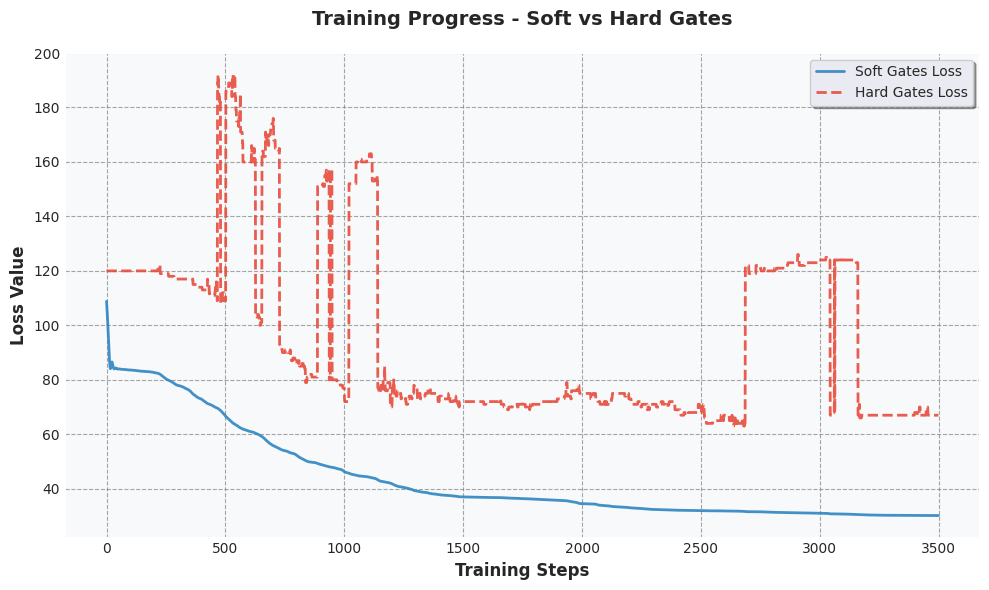

In [26]:
"""
for i in range(START_EPOCH, hyperparams['num_epochs']):
  train_state, soft_loss, hard_loss = train_step(
      train_state,
      train_x,
      train_y,
      wires,
      hyperparams['periodic'],
      hyperparams['num_steps'],
      hyperparams['async_training'],
      adjacency_indices_padded_lizard,
  )
  loss_soft.append(soft_loss)
  loss_hard.append(hard_loss['hard'])

  if i % 5 == 0:
    clear_output(wait=True)
    plot_training_progress(loss_soft, loss_hard, 1)
    print(i, soft_loss, hard_loss['hard'])
    
  # 💾 LÓGICA DE CHECKPOINT PERIÓDICO
  # Guarda el estado cada SAVE_FREQ épocas
  if (i + 1) % SAVE_FREQ == 0:
      save_checkpoint(train_state, i + 1)


# -------------------------------------------------------------
# 🏁 GUARDADO FINAL AL CONCLUIR EL ENTRENAMIENTO
# -------------------------------------------------------------
clear_output(wait=True)

# 1. Guardar la versión final del estado
final_epoch = hyperparams['num_epochs']
save_checkpoint(train_state, final_epoch)
print(f"\n--- ENTRENAMIENTO FINALIZADO ---")
print(f"Modelo final (TrainState) guardado en la época {final_epoch}.")



# 2. Guardar la gráfica final
plot_training_progress(loss_soft, loss_hard, 1, 'lizard_logo_loss.svg')"""

In [36]:
#INICIO SIMULACION

In [25]:
# @title Cargar el Estado Completo del Kernel
#para cargar , cargar antes, cuda, os, imports y train state
# Cargar los datos
with open('./resultados_lizard_k8/session_final_state.pkl', 'rb') as f:
    loaded_vars = pickle.load(f)

# Restaurar las variables en el namespace global
globals().update(loaded_vars)
print("Variables restauradas en el kernel.")

Variables restauradas en el kernel.


(20, 20, 128)


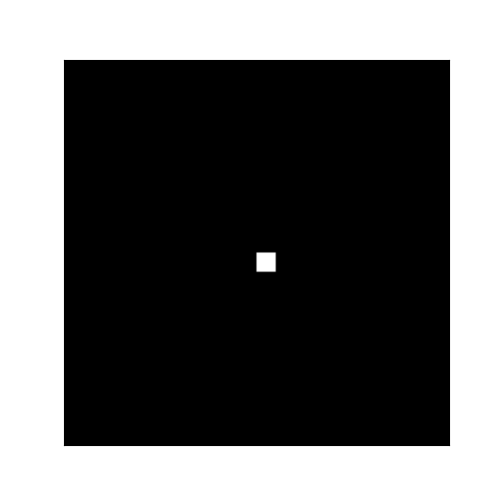

In [26]:
"""Growing the Lizard

Visualization of the recurrent dynamics of the learned circuit.
"""

grid = train_x[0]

params, opt_state, key = train_state
wires = wires
training = False
periodic = True

print(grid.shape)
frames = []
nca_state = grid
frames.append(zoom(nca_state[:, :, 0], 8))
for i in range(12):
  nca_state = run_sync(nca_state, params, wires, training, periodic, adjacency_indices_padded_lizard)
  frames.append(zoom(nca_state[:, :, 0], 8))

visualize(frames, 'lizard.gif', 5)
Image('lizard.gif')

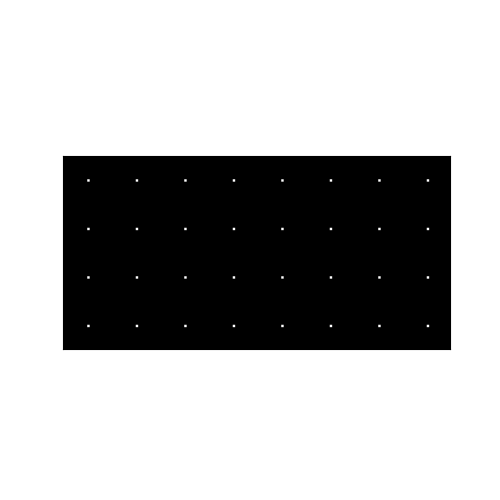

In [27]:
"""Growing the Lizard: visualization of the hidden states
Visualization of the first 32 channels
"""

params, opt_state, key = train_state
wires = wires
training = False
periodic = True

frames = []

nca_state = train_x[0]
# Create subplot grid for all 32 channels
initial_grid = np.vstack([
    np.hstack([zoom(nca_state[:, :, 8 * j + i], 4) for i in range(8)])
    for j in range(4)
])
frames.append(initial_grid)

for i in range(12):
  nca_state = run_sync(nca_state, params, wires, training, periodic, adjacency_indices_padded_lizard)
  channel_grid = np.vstack([
      np.hstack([zoom(nca_state[:, :, 8 * j + i], 4) for i in range(8)])
      for j in range(4)
  ])
  frames.append(channel_grid)

visualize(frames, 'hidden_lizard.gif', 5)
Image('hidden_lizard.gif')

In [28]:
#Celda de visualizacion Grafo

# Usamos G_lizard_k8, creado en la Celda ~34.
# N_total_nodes es 400 para el Lizard (20*20).

# 1. Fijar las posiciones de los nodos usando un algoritmo de NetworkX (ej. spring_layout)
# Se recomienda usar el mismo 'seed' para la reproducibilidad del layout:
pos = nx.spring_layout(G_lizard_k8, seed=42) 

# 2. Simular para obtener los datos de la animación
# DEBES obtener la secuencia de estados del CA (nodos en formato 1D: N_nodos x C)
# Esto requiere una función de simulación que devuelva una lista de estados.
# Por ahora, solo simula y guarda los estados.

# NOTA: Debes ejecutar la simulación y guardar los estados 
# (ej. solo el Canal 0) en una lista llamada `states_history`.
# Puedes reutilizar la lógica de run_sync, pero guardando todos los pasos.

In [29]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def update_animation(frame_num, G, pos, states_history, ax):
    ax.clear()

    # Obtener el estado del CA para este frame (ej. solo el Canal 0, el estado visible)
    current_state = states_history[frame_num][..., 0] 

    # Mapear el estado del nodo a un color
    # Usaremos el estado del nodo para el color (ej. 1.0 = Rojo, 0.0 = Azul)
    node_colors = plt.cm.RdYlBu(current_state) 

    # 1. Dibujar las aristas del grafo (estructura fija)
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.5, edge_color='gray')

    # 2. Dibujar los nodos con el color mapeado al estado actual
    nx.draw_networkx_nodes(
        G, 
        pos, 
        node_color=node_colors, 
        node_size=20, # Tamaño fijo del nodo
        ax=ax
    )

    ax.set_title(f"Paso de Evolución: {frame_num}")

In [30]:
# Bloque de Simulación y Recolección de Estados (DEBE EJECUTARSE)
N_SIMULATION_STEPS = 50 
states_history = []
nca_state = train_x[0].copy() 

for i in range(N_SIMULATION_STEPS):
    # Convertir a 1D antes de guardar (para el formato de grafo)
    states_history.append(nca_state.reshape(-1, nca_state.shape[-1])) 

    # Aplicar un paso de la CA del grafo k=8
    nca_state = run_sync(
        nca_state, 
        params, 
        wires, 
        False, 
        True,
        adjacency_indices_padded_lizard
    )
    # nca_state está en formato 3D aquí (N, N, C)

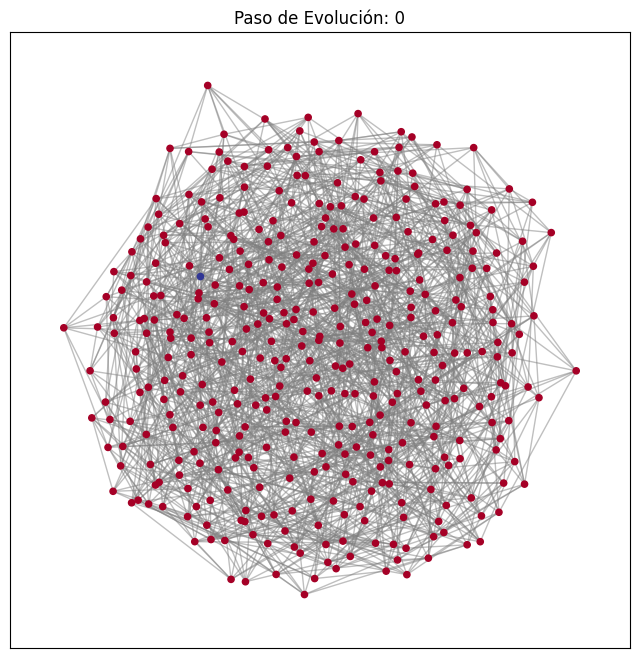

In [31]:
# Asumimos que 'states_history' contiene N_steps arrays de shape (N_nodes, C)
N_steps = len(states_history) 

fig, ax = plt.subplots(figsize=(8, 8))

ani = animation.FuncAnimation(
    fig, 
    update_animation, 
    frames=N_steps, 
    fargs=(G_lizard_k8, pos, states_history, ax), # Argumentos para update_animation
    interval=200, # 5 frames por segundo (1000ms / 200)
    blit=False, 
    repeat=True
)

# Para guardar en MP4 (puede requerir ffmpeg):
ani.save('animated_lizard_graph2.mp4', writer='ffmpeg', fps=5)

TOTAL GATES:   1028


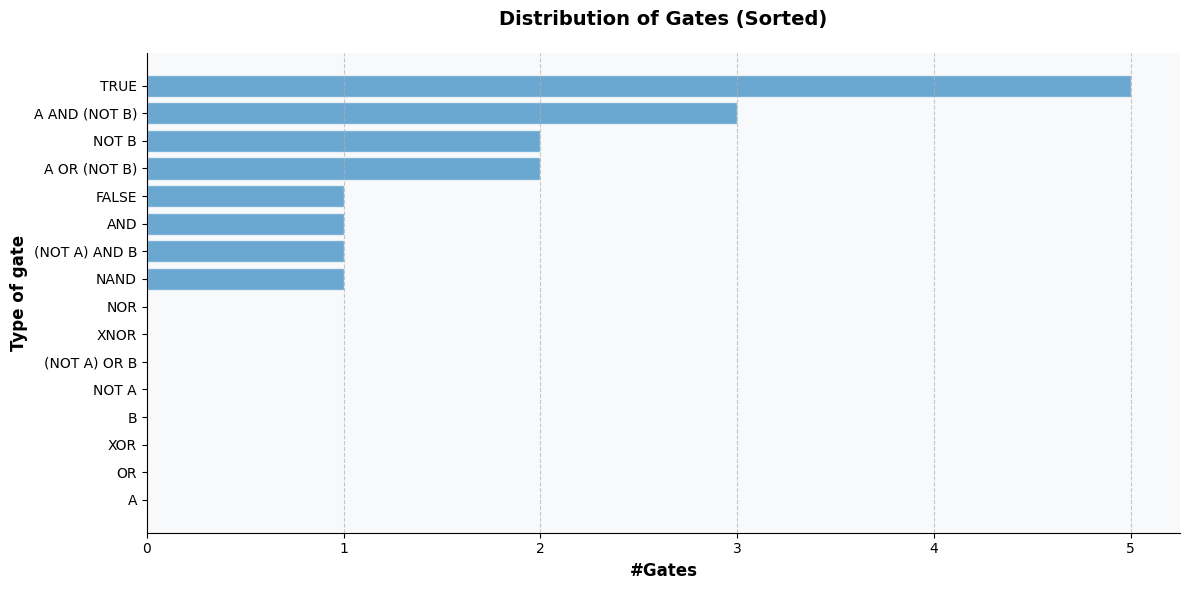

In [32]:
"""Analysis of Gate Distributions:

This section investigates the learned gate distributions
for the Update and Perceive Networks in the growing Lizard model.
"""

params, opt_state, key = train_state
analyze_circuit = jax.tree_util.tree_map(
    lambda x: jax.numpy.argmax(x, axis=-1), params
)
count_gates = jax.tree_util.tree_map(
    lambda x: ((x != 3) & (x != 5)).sum(), analyze_circuit
)
total_gates = sum(x for x in jax.tree_util.tree_leaves(count_gates))
print('TOTAL GATES:  ', total_gates)

perceive_networks = analyze_circuit['perceive']
update_networks = analyze_circuit['update']

# Perceive Network
perceive_networks_stats = [
    x.reshape(-1) for x in jax.tree_util.tree_leaves(perceive_networks)
]
perceive_net = jax.numpy.concatenate(perceive_networks_stats, axis=0)
perceive_net = perceive_net[((perceive_net != 3) & (perceive_net != 5))]


plot_hist_gates(
    perceive_net,
    'lizard_perceive_gates.svg',
    'Distribution of Gates (Perceive Network)',
)

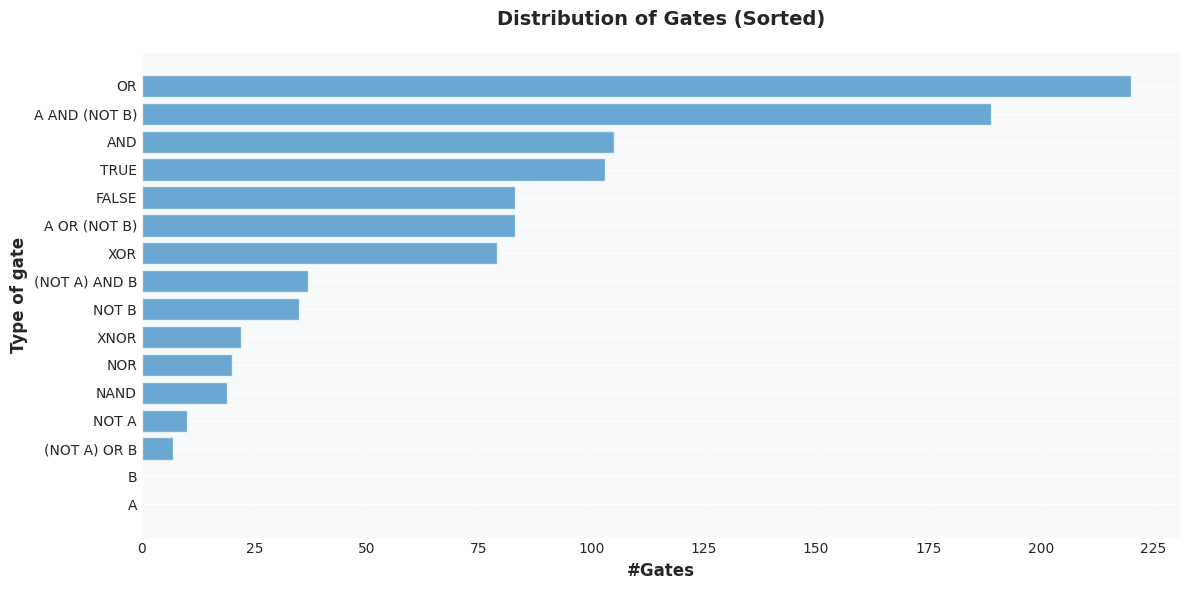

In [33]:
# Update Network
update_networks_stats = [
    x.reshape(-1) for x in jax.tree_util.tree_leaves(update_networks)
]
update_net = jax.numpy.concatenate(update_networks_stats, axis=0)
update_net = update_net[((update_net != 3) & (update_net != 5))]

plot_hist_gates(
    update_net,
    'lizard_update_gates.svg',
    'Distribution of Gates (Update Network)',
)

In [35]:
# @title Guardar el Estado Completo del Kernel

# Define la ruta y nombre del archivo
OUTPUT_DIR = './resultados_lizard_k8/'
os.makedirs(OUTPUT_DIR, exist_ok=True)
SESSION_FILE = os.path.join(OUTPUT_DIR, 'session_final_state.pkl')

print("Guardando todas las variables del kernel...")

# 1. Filtra las variables globales
# Excluye módulos importados para evitar errores de serialización
global_vars = globals().copy()
data_to_save = {
    'hyperparams': hyperparams,
    'train_state': train_state,
    'wires': wires,
    'adjacency_indices_padded_lizard': adjacency_indices_padded_lizard,
    'G_lizard_k8': G_lizard_k8, # NetworkX Graph puede ser pickleado
    'loss_soft': loss_soft,
    'loss_hard': loss_hard,
}

# 2. Guarda el diccionario de variables en el archivo
try:
    with open(SESSION_FILE, 'wb') as f:
        pickle.dump(data_to_save, f)
    
    print(f"✅ Estado completo del kernel guardado en: {SESSION_FILE}")
    print(f"Número de variables guardadas: {len(data_to_save)}")
    
except Exception as e:
    print(f"❌ ERROR al guardar el estado del kernel: {e}")

Guardando todas las variables del kernel...
✅ Estado completo del kernel guardado en: ./resultados_lizard_k8/session_final_state.pkl
Número de variables guardadas: 7
